### Степень принадлежности узла к классу оценивается с помощью эвристик: 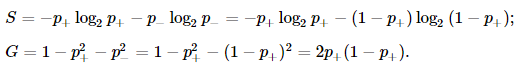

### S - энтропия Шеннона, G - коэффициент Джини

## Коэффициент усиления информации при разделении (для энтропии)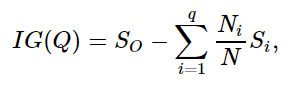

#### Ni - количество элементов в разделении, N - общая сумма элементов, Si - энтропия разделения (правой или левой части), S0 - энтропия до разделения

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons

In [71]:
class DecisionTree:
    
    def __init__(self, max_depth, min_size):
        self.max_depth = max_depth
        self.min_size = min_size
    
    #вычисление индекса Джини
    def _gini_index(self,groups):
        groups = np.array(groups)
        #все имеющие классы в разделении
        #в последней колонке значение класса
        classes = np.unique(np.hstack([np.array(group)[:,-1] for group in groups if len(group) != 0 ]))   
        # посчитать общее количество элементов в разделенных группах 
        N = sum([len(group) for group in groups])
        # суммируем веса индексов Джини каждой группы, чтобы найти коэффициент усиления информации, на основе имеющегося разделения
        gini = 0.0
        for group in groups:
            Ni = len(group)
            # избежание деления на 0
            if Ni == 0:
                continue
            score = 0.0
            # рассчёт коэффициента Джини для группы
            for class_val in classes:
                p = list(group[:,-1]).count(class_val)/Ni
                score += p * p
            # общий коэффициент с учетом относительного размера групп
            gini += (1.0 - score) * (Ni/N)
        return gini    
    
    
    # разделение выборки по условию меньше значения переданного атрибута value (value будет перебираться
    # и тестироваться на эвристиках, по итогу будет выбран атрибут, дающий лучшие эвристики по разделению)
    #сравнение идет по какому-то конретному параметру элементов, который так же задается вместе с value, и также будет перебираться
    def _simple_split(self, feature_number, value, dataset):
        # feature_number фича (номер одной из характеристик/параметра/координаты вектора (называй как хочешь)
        #по которым задаются элементы датасета)
        #будем сравнивать по одной из фич
        left, right = list(), list()
        for element in dataset:
            if element[feature_number] < value:
                left.append(element)
            else:
                right.append(element)
        return np.array(left), np.array(right)
    
    # Находим лучшее разделение
    def _get_split(self, dataset):
        b_feature_n, b_value, b_score, b_groups = 999, 999, 999, None
        #вот тут и начинается перебор
        #перебераем все элементы датасета по фичам и смотрим разделение по какому будет самым лучшим
        for feature_num in range(len(dataset[0])-1):
            for element in dataset:
                groups = self._simple_split(feature_num, element[feature_num], dataset)                              
                h_metric = self._gini_index(groups)  
                if h_metric < b_score:
                    b_feature_n, b_value, b_score, b_groups = feature_num, element[feature_num], h_metric, groups
        return  {'feature_number':b_feature_n, 'value':b_value, 'groups':b_groups}
    
    # конечное значение узла
    def _assign_predict(self, group):
        outcomes = np.array(group)[:,-1]
        return max(set(outcomes), key=list(outcomes).count)
    
    # делим узлы дерева до стоп-фактора и назначаем метку класса конечным узлам
    def _split(self, node, max_depth, min_size, depth = 1):
        left, right = node['groups']
        del(node['groups'])
        # проверка отсутсвия разделений
        if not list(left) or not list(right):
            node['left'] = node['right'] = self._assign_predict(list(left)+list(right))
            return
        # проверка глубины дерева
        if depth >= max_depth:
            node['left'], node['right'] = self._assign_predict(left), self._assign_predict(right)
            return
        # делим левый узел или назначаем класс
        if len(left) <= min_size:
            node['left'] = self._assign_predict(left)
        else:
            node['left'] = self._get_split(left)
            self._split(node['left'], max_depth, min_size, depth+1)
        # делим правый узел или назначаем класс
        if len(right) <= min_size:
            node['right'] = self._assign_predict(right)
        else:
            node['right'] = self._get_split(right)
            self._split(node['right'], max_depth, min_size, depth+1)
    
    # Build up the tree
    def fit(self, train_data):
        root = self._get_split(train_data)
        self._split(root, self.max_depth, self.min_size)
        self._root = root
    
        
    def _predict_element(self, node, element):
        if element[node['feature_number']] < node['value']:
            if isinstance(node['left'], dict):
                return self._predict_element(node['left'], element.copy())
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self._predict_element(node['right'], element.copy())
            else:
                return node['right']    
    
    def predict(self, test_data):
        predictions = []
        for element in test_data:
            predictions.append(self._predict_element(self._root, element))
        return predictions
    

In [72]:
x, y = make_moons(n_samples=100, noise=0.1)

In [76]:
tree = DecisionTree(5,1)

In [77]:
tree.fit(np.hstack((x,y.reshape(-1,1))))

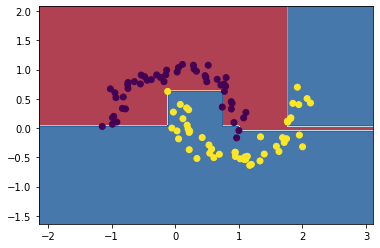

In [78]:
h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree.predict(np.stack((xx0.ravel(),xx1.ravel())).T)

Z = np.array(Z).reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)
plt.show()